In [197]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, vstack, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16}) #make plots more readable

import MagellanicStream as ms
import astropy.units as u
from astropy.coordinates import SkyCoord
from uncertainties import ufloat

import warnings
warnings.filterwarnings('ignore')

import glob

In [198]:
##############################
### User defined functions ###
##############################

def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

import pandas as pd #needed for readbasti
def readbasti(file):
    with open(file) as f:
        lines = f.readlines()
        met_age = lines[4].split(' ')
        met = float(met_age[9]) #9th element after line[4] split
        age = float(met_age[-1]) #last element after line[4] split
        df = pd.read_csv(file,comment='#',names=['MINI','MFIN','LOGL','LOGT','JMAG','HMAG','KMAG'],sep='\s+')
        table_out = Table.from_pandas(df)
        metcol = Column(np.ones(len(table_out))*met, name='FEH')
        table_out.add_column(metcol)
        agecol = Column(np.log10(np.ones(len(table_out))*(age*10**6)), name='LOGAGE')
        table_out.add_column(agecol)
        mas = df['MFIN']*(1.99*10**33) #mass in g
        tem = 10**df['LOGT'] #T in K
        lum = (10**df['LOGL'])*(3.9*10**33) #L in erg/s
        lggcol = Column(np.log10((6.67259*10**-8)*(mas)*4*np.pi*(5.67051*10**-5)*(tem**4)/(lum)),name='LOGG')
        table_out.add_column(lggcol)
    return table_out

def mad(dat):
    return np.median(np.absolute(dat - np.median(dat)))

def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [199]:
####################################
### Import Globular Cluster Data ###
####################################

#Globular Cluster Star Data
filepath1 = '/Users/joshpovick/desktop/research/magellanic_ages/globulars/allStar-r12-l33beta_clean_nodup_gc.fits'
gcs = Table(fits.getdata(filepath1,0))

#Globular Cluster Params
filepath2 = '/Users/joshpovick/desktop/research/magellanic_ages/globulars/gc_param.txt'
hayes = pd.read_csv(filepath2,comment='#',names=['cluster','rah','ram','ras','decd','decm','decs','concen','r_c',\
                                              'r_t','feh','vhelio','sigma_v'],sep='\s+')

#Tables from https://doi.org/10.1093/mnras/stx544
filepath3 = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/globulars/SupplemetaryTable2.txt'
filepath4 = '/Users/joshpovick/Desktop/Research/Magellanic_Ages/globulars/SupplemetaryTable3.txt'
supp2 = pd.read_csv(filepath3,comment='#',names=['Cluster','Dist','Dist_Sigma','Av','Av_Sigma','[Fe/H]','Age'],\
                    sep='\s+')
supp3 = pd.read_csv(filepath4,comment='#',names=['Name','[Fe/H]','Dist','Distupperr','Distlowerr','Av','Avuperr',\
                                                 'Avlowerr','Y','Yuperr','Ylowerr','log(Age)','log(Age)uperr',\
                                                 'log(Age)lowerr','Age(Gyr)','Age(Gyr)uperr','Age(Gyr)lowerr',\
                                                 'RelativeAge'],\
                    sep='\s+')

In [200]:
hayes['cluster']

0     47TUC
1        M2
2        M3
3        M5
4       M12
5       M13
6       M15
7       M53
8       M92
9      M107
10    N4147
11    N5053
12    N5466
13    N5634
14       M4
15      M10
16      M55
17      M68
18      M71
19      M79
20     N362
21    N1851
22    N2808
23    N3201
24    N6229
25    N6388
26    N6397
27    N6752
28     PAL5
29     OCEN
Name: cluster, dtype: object

In [201]:
##############
### Models ###
##############

'''
x1: logT
x2: K
x3: feh
x4: logg
'''

def bestparsec(x1,x2,x3,x4):
    p = [ 4.76880995e+02, -2.59168919e+02,  1.48709599e+00, -1.17413263e+00,\
        1.53939504e+01,  4.76073940e-01,  3.20577341e-01, -6.48790879e+00,\
       -2.81019235e-03, -6.63402770e-01,  3.71990193e+01,  1.32198710e-01,\
        9.66665908e-01]
    return p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*np.multiply(x1,x2)+p[6]*np.multiply(x1,x3)+\
p[7]*np.multiply(x1,x4)+p[8]*np.multiply(x2,x3)+p[9]*np.multiply(x2,x4)+p[10]*(x1**2)+p[11]*(x2**2)+p[12]*(x4**2)
   
    
def bestbasti(x1,x2,x3,x4):
    p = [ 6.24590560e+01, -1.02980629e+01,  8.20530934e+00,  4.68358995e+00,\
       -1.68242650e+01, -1.41774849e+00, -1.39823960e+00,  2.80833527e+00,\
       -4.72902247e-02, -5.48881225e-01,  1.87500272e-01,  1.27975813e-01,\
        5.59894274e-01]
    return p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*np.multiply(x1,x2)+p[6]*np.multiply(x1,x3)+\
p[7]*np.multiply(x1,x4)+p[8]*np.multiply(x2,x3)+p[9]*np.multiply(x2,x4)+p[10]*np.multiply(x3,x4)+\
p[11]*(x2**2)+p[12]*(x4**2)

def bestmist(x1,x2,x3,x4):
    p = [11.95633625,  4.29637009,  3.47288991,  0.24495181, -6.09562956,\
       -0.61658645, -0.69137712,  0.14681993,  0.06654658,  0.82262236]
    return p[0]+p[1]*x1+p[2]*x2+p[3]*x3+p[4]*x4+p[5]*np.multiply(x1,x4)+p[6]*np.multiply(x2,x4)+\
p[7]*(x2**2)+p[8]*(x3**2)+p[9]*(x4**2)

In [220]:
#####################
### Ages And Dist ###
#####################

cluster_ages = {'47TUC':-9999.0,'M10':12.846,'M107':13.477,'M12':13.496,'M13':13.094,'M15':13.499,'M2':-9999.0,\
                'M3':12.585,'M4':12.966,'M5':12.007,'M53':13.498,'M55':13.498,'M68':12.803,'M71':13.493,\
                'M79':-9999.0,'M92':13.498,'N1851':-9999.0,'N2808':-9999.0,'N3201':12.836,'N362':-9999.0,\
                'N4147':13.261,'N5053':13.493,'N5466':13.410,'N6229':-9999.0,'N6388':-9999.0,'N6397':13.496,\
                'N6752':-9999.0,'OCEN':-9999.0}

cluster_dist = {'47TUC':-9999.0,'M10':14.435,'M107':15.013,'M12':14.178,'M13':14.442,'M15':15.431,'M2':-9999.0,\
                'M3':15.081,'M4':12.798,'M5':14.443,'M53':16.409,'M55':13.965,'M68':15.247,'M71':13.716,\
                'M79':-9999.0,'M92':14.724,'N1851':-9999.0,'N2808':-9999.0,'N3201':14.189,'N362':-9999.0,\
                'N4147':16.444,'N5053':16.235,'N5466':16.004,'N6229':-9999.0,'N6388':-9999.0,'N6397':12.540,\
                'N6752':-9999.0,'OCEN':-9999.0}

gc_age = []
gc_dist = []
for i in range(len(gcs)):
    gc_age.append(cluster_ages[gcs['CLUSTER'][i]])
    gc_dist.append(cluster_dist[gcs['CLUSTER'][i]])
    
gc_age = np.asarray(gc_age)
cln = np.where(gc_age!=-9999.0)
cln_age = np.log10(gc_age[cln]*(10**9))
cln_gcs = gcs[cln]
cln_dist = np.asarray(gc_dist)[cln]

first = np.where(cln_gcs['AL_FE']<=0.4)

In [221]:
cln_gcs.columns

<TableColumns names=('APSTAR_ID','TARGET_ID','ASPCAP_ID','FILE','APOGEE_ID','TELESCOPE','LOCATION_ID','FIELD','J','J_ERR','H','H_ERR','K','K_ERR','RA','DEC','GLON','GLAT','APOGEE_TARGET1','APOGEE_TARGET2','APOGEE_TARGET3','APOGEE2_TARGET1','APOGEE2_TARGET2','APOGEE2_TARGET3','TARGFLAGS','SURVEY','PROGRAMNAME','NINST','NVISITS','COMBTYPE','COMMISS','SNR','STARFLAG','STARFLAGS','ANDFLAG','ANDFLAGS','VHELIO_AVG','VSCATTER','VERR','VERR_MED','OBSVHELIO_AVG','OBSVSCATTER','OBSVERR','OBSVERR_MED','SYNTHVHELIO_AVG','SYNTHVSCATTER','SYNTHVERR','SYNTHVERR_MED','RV_TEFF','RV_LOGG','RV_FEH','RV_ALPHA','RV_CARB','RV_CCFWHM','RV_AUTOFWHM','SYNTHSCATTER','STABLERV_CHI2','STABLERV_RCHI2','CHI2_THRESHOLD','STABLERV_CHI2_PROB','MEANFIB','SIGFIB','SNREV','APSTAR_VERSION','ASPCAP_VERSION','RESULTS_VERSION','EXTRATARG','MIN_H','MAX_H','MIN_JK','MAX_JK','PARAM','FPARAM','PARAM_COV','FPARAM_COV','TEFF','TEFF_ERR','LOGG','LOGG_ERR','VMICRO','VMACRO','VSINI','M_H','M_H_ERR','ALPHA_M','ALPHA_M_ERR','ASPCAP_CHI

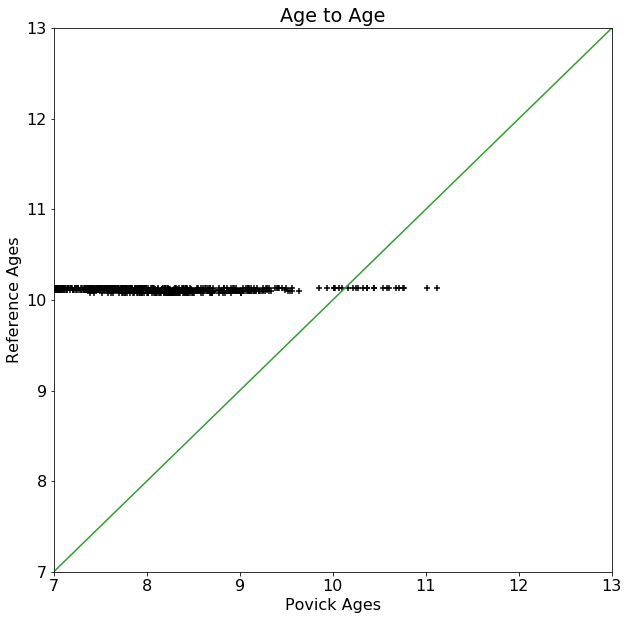

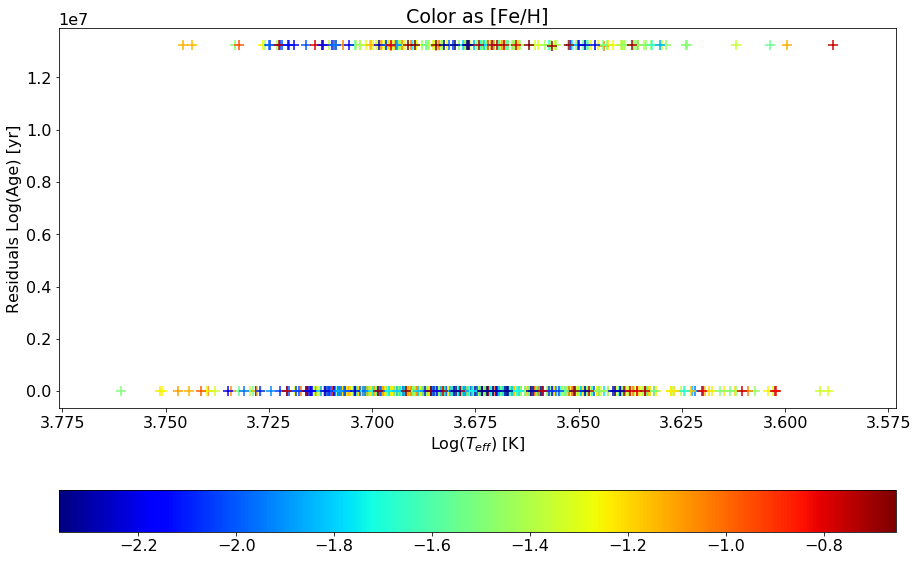

In [222]:
##################
### Cal PARSEC ###
##################

absK = absmag(cln_gcs['K'],cln_dist,False)-cln_gcs['AK_TARG']
salfeh = sal(cln_gcs['M_H'],cln_gcs['ALPHA_M'])
parsec_age = bestparsec(np.log10(cln_gcs['TEFF']),absK,salfeh,cln_gcs['LOGG'])

plt.figure(figsize=[10,10])
plt.scatter(parsec_age[first],cln_age[first],c='k',marker='+')
plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='tab:green')
plt.ylim(7,13)
plt.xlim(7,13)
plt.xlabel(r'Povick Ages')
plt.ylabel(r'Reference Ages')
plt.title(r'Age to Age')
plt.show()

plt.figure(figsize=[15,10])
plt.scatter(np.log10(cln_gcs['TEFF'])[first],(parsec_age-np.log10(gc_age[cln]*(10**9)))[first],c=cln_gcs['FE_H'][first],marker='+',s=100,cmap='jet')
plt.gca().invert_xaxis()
plt.colorbar(orientation='horizontal')
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Log($T_{eff})$ [K]')
plt.ylabel(r'Residuals Log(Age) [yr]')
plt.show()

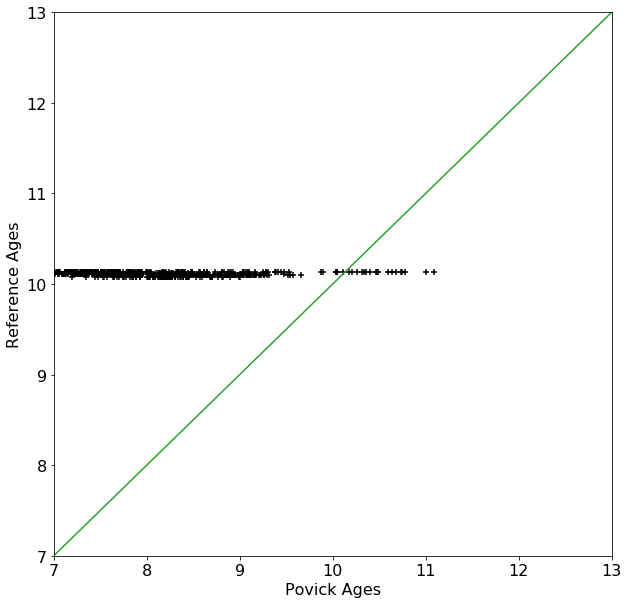

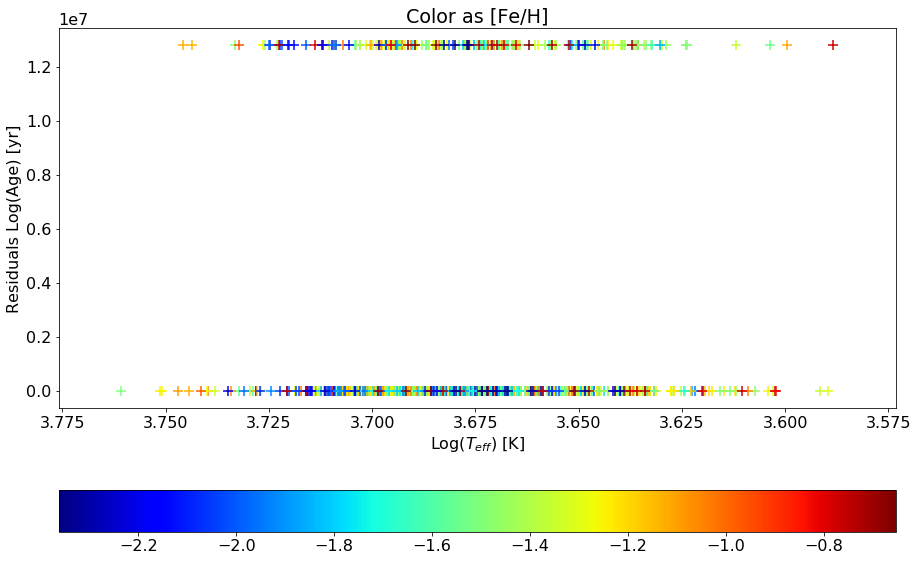

In [223]:
#################
### Cal BaSTI ###
#################

absK = absmag(cln_gcs['K'],cln_dist,False)-cln_gcs['AK_TARG']
salfeh = sal(cln_gcs['M_H'],cln_gcs['ALPHA_M'])
basti_age = bestbasti(np.log10(cln_gcs['TEFF']),absK,salfeh,cln_gcs['LOGG'])

plt.figure(figsize=[10,10])
plt.scatter(basti_age[first],cln_age[first],c='k',marker='+')
plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='tab:green')
plt.ylim(7,13)
plt.xlim(7,13)
plt.xlabel(r'Povick Ages')
plt.ylabel(r'Reference Ages')
plt.show()

plt.figure(figsize=[15,10])
plt.scatter(np.log10(cln_gcs['TEFF'])[first],(basti_age-np.log10(gc_age[cln]*(10**9)))[first],c=cln_gcs['FE_H'][first],marker='+',s=100,cmap='jet')
plt.gca().invert_xaxis()
plt.colorbar(orientation='horizontal')
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Log($T_{eff})$ [K]')
plt.ylabel(r'Residuals Log(Age) [yr]')
plt.show()

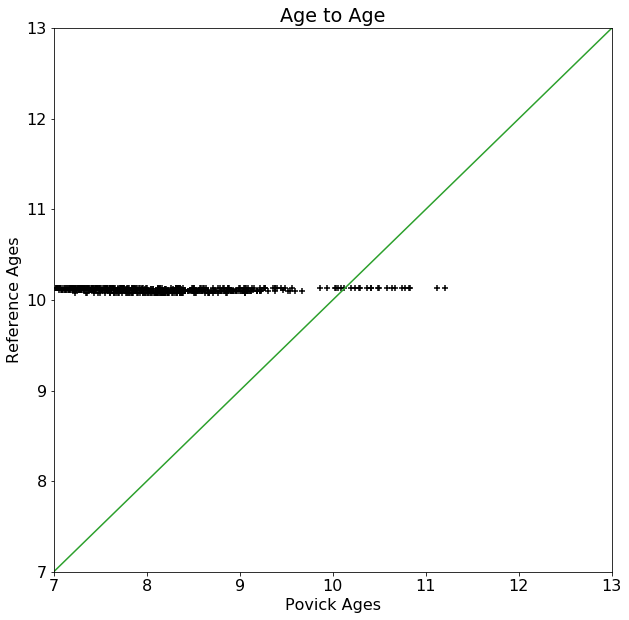

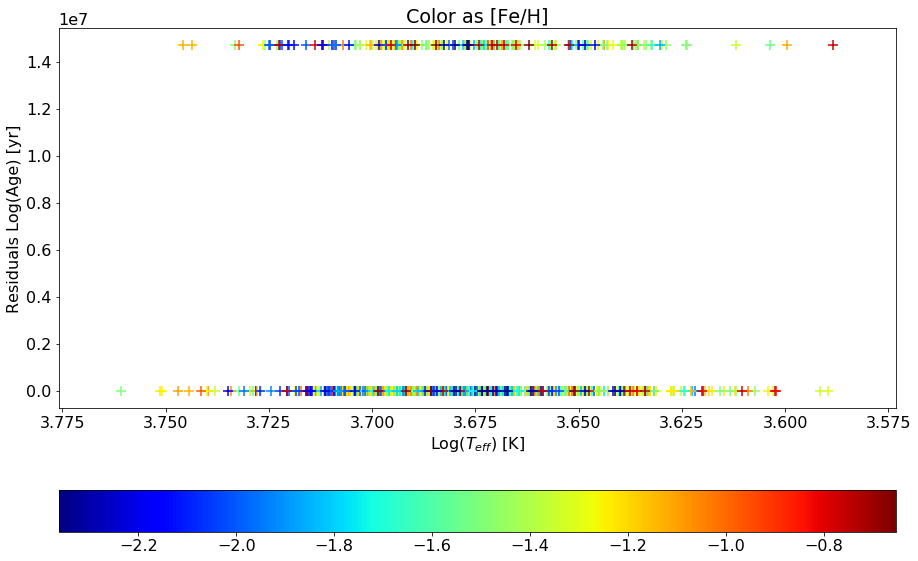

In [224]:
################
### Cal MIST ###
################

absK = absmag(cln_gcs['K'],cln_dist,False)-cln_gcs['AK_TARG']
salfeh = sal(cln_gcs['M_H'],cln_gcs['ALPHA_M'])
mist_age = bestmist(np.log10(cln_gcs['TEFF']),absK,salfeh,cln_gcs['LOGG'])

plt.figure(figsize=[10,10])
plt.scatter(mist_age[first],cln_age[first],c='k',marker='+')
plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='tab:green')
plt.ylim(7,13)
plt.xlim(7,13)
plt.xlabel(r'Povick Ages')
plt.ylabel(r'Reference Ages')
plt.title(r'Age to Age')
plt.show()

plt.figure(figsize=[15,10])
plt.scatter(np.log10(cln_gcs['TEFF'])[first],(mist_age-np.log10(gc_age[cln]*(10**9)))[first],c=cln_gcs['FE_H'][first],marker='+',s=100,cmap='jet')
plt.gca().invert_xaxis()
plt.colorbar(orientation='horizontal')
plt.title(r'Color as [Fe/H]')
plt.xlabel(r'Log($T_{eff})$ [K]')
plt.ylabel(r'Residuals Log(Age) [yr]')
plt.show()

In [226]:
set(cln_gcs['FE_H'][first])

{-2.3628664,
 -2.3558664,
 -2.3490663,
 -2.3488662,
 -2.3443663,
 -2.3442664,
 -2.3433664,
 -2.3388662,
 -2.3369663,
 -2.3350663,
 -2.3346663,
 -2.3344662,
 -2.3327663,
 -2.3311663,
 -2.3294663,
 -2.3278663,
 -2.3270664,
 -2.3226664,
 -2.3208663,
 -2.3204663,
 -2.3192663,
 -2.3184664,
 -2.3147664,
 -2.3144662,
 -2.3121662,
 -2.3071663,
 -2.3070662,
 -2.3059664,
 -2.3010664,
 -2.2854664,
 -2.2755663,
 -2.2752664,
 -2.2636664,
 -2.2630663,
 -2.2602663,
 -2.2592664,
 -2.2590663,
 -2.2551663,
 -2.2519662,
 -2.2511663,
 -2.2506664,
 -2.2472663,
 -2.2465663,
 -2.2436664,
 -2.2402663,
 -2.2391663,
 -2.2363663,
 -2.2329664,
 -2.2287662,
 -2.2234664,
 -2.2232664,
 -2.2220664,
 -2.2207663,
 -2.2204664,
 -2.2122662,
 -2.2064662,
 -2.1999664,
 -2.1932664,
 -2.1920664,
 -2.1891663,
 -2.1834664,
 -2.1817663,
 -2.1717663,
 -2.1668663,
 -2.1507664,
 -2.1405663,
 -2.1370664,
 -2.1323664,
 -2.1297662,
 -2.1281662,
 -2.1246662,
 -2.1200664,
 -2.1161664,
 -2.1143663,
 -2.1060662,
 -2.0907664,
 -2.0876663,